In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

df = pd.read_csv('sepsis_cohort_features.csv')

# Convert timestamp column
df['interval_4h'] = pd.to_datetime(df['interval_4h'])

# Basiv data preprocessing
#  Handle Missing Values
def impute_missing_values(df):
    # Group by patient and sort by time
    df = df.sort_values(['icustay_id', 'interval_4h'])

    # Ffill temporal features
    temporal_features = ['heart_rate', 'map', 'spo2', 'respiratory_rate',
                        'temperature', 'systolic_bp', 'diastolic_bp']

    df[temporal_features] = df.groupby('icustay_id')[temporal_features].ffill()

    # Fill with group medians
    lab_features = ['lactate', 'creatinine', 'platelets', 'bun', 'wbc',
                   'bicarbonate', 'sodium', 'potassium', 'bilirubin']
    df[lab_features] = df.groupby('icustay_id')[lab_features].transform(
        lambda x: x.fillna(x.median()))

    # Binary features: fill with 0 assuming treatment has not administerd
    treatment_features = ['norepinephrine', 'dopamine', 'dobutamine',
                         'epinephrine', 'vasopressin', 'mechanical_vent']
    df[treatment_features] = df[treatment_features].fillna(0)

    # Demographic features are fill with population median
    df['weight'] = df['weight'].fillna(df['weight'].median())
    df['height'] = df['height'].fillna(df['height'].median())

    return df

df_clean = impute_missing_values(df)

# Feature Engineering
def create_state_action_reward(df):
    # Sort by patient id and time
    df = df.sort_values(['icustay_id', 'interval_4h'])

    # Creatiing next state and mortality flag
    df['next_mortality'] = df.groupby('icustay_id')['mortality_48h_flag'].shift(-1)
    df['done'] = df.groupby('icustay_id').cumcount(ascending=False) == 0

    # Defining reward function
    df['reward'] = df['next_mortality'].apply(lambda x: -1.0 if x == 1 else 0.0)

    # Defining state and action columns
    state_features = [col for col in df.columns if col not in
                     ['subject_id', 'hadm_id', 'icustay_id', 'interval_4h',
                      'mortality_48h_flag', 'next_mortality', 'reward', 'done']]

    action_features = ['norepinephrine', 'dopamine', 'dobutamine',
                      'epinephrine', 'vasopressin', 'crystalloids',
                      'colloids', 'mechanical_vent']
    state_features = [col for col in state_features if col not in action_features]

    return df, state_features, action_features

df_processed, state_features, action_features = create_state_action_reward(df_clean)

In [24]:
df_processed.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_4h', 'gender', 'age',
       'ethnicity', 'weight', 'height', 'heart_rate', 'map', 'spo2',
       'respiratory_rate', 'temperature', 'systolic_bp', 'diastolic_bp',
       'gcs_total', 'fio2', 'peep', 'lactate', 'creatinine', 'platelets',
       'bun', 'wbc', 'bicarbonate', 'sodium', 'potassium', 'bilirubin',
       'hematocrit', 'glucose', 'pao2', 'ph', 'pco2', 'norepinephrine',
       'dopamine', 'dobutamine', 'epinephrine', 'vasopressin', 'crystalloids',
       'colloids', 'mechanical_vent', 'hours_since_icu_admission',
       'mortality_48h_flag', 'next_mortality', 'done', 'reward'],
      dtype='object')

In [25]:
state_features

['gender',
 'age',
 'ethnicity',
 'weight',
 'height',
 'heart_rate',
 'map',
 'spo2',
 'respiratory_rate',
 'temperature',
 'systolic_bp',
 'diastolic_bp',
 'gcs_total',
 'fio2',
 'peep',
 'lactate',
 'creatinine',
 'platelets',
 'bun',
 'wbc',
 'bicarbonate',
 'sodium',
 'potassium',
 'bilirubin',
 'hematocrit',
 'glucose',
 'pao2',
 'ph',
 'pco2',
 'hours_since_icu_admission']

In [26]:
len(state_features)

30

In [27]:
df_processed[action_features].describe()

,norepinephrine,dopamine,dobutamine,epinephrine,vasopressin,crystalloids,colloids,mechanical_vent
count,662158.000000,662158.000000,662158.000000,662158.000000,662158.000000,662158.000000,662158.000000,662158.000000
mean,0.005492,1.635619,0.000220,0.001721,0.000309,53.632872,0.668181,0.530464
std,0.188350,17.223746,0.018853,0.124301,0.023409,182.037498,17.428553,0.499071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,1.000000
max,76.808000,1257.300000,13.063484,67.719256,15.008470,18000.000000,1500.000000,1.000000


In [ ]:
df_processed['gender'] = df_processed['gender'].map({'M': 0, 'F': 1})
df_processed['ethnicity'] = df_processed['ethnicity'].astype('category').cat.codes  # simple encoding
df_processed[state_features] = df_processed.groupby('icustay_id')[state_features].ffill()
transitions = []

In [30]:
df = df_processed.copy()

In [ ]:
df_processed[state_features] = df_processed[state_features].fillna(df[state_features].median())

In [ ]:
# convertitng 4-hour interval column to datetime
df_processed['interval_4h'] = pd.to_datetime(df_processed['interval_4h'], errors='coerce', infer_datetime_format=True)

# rows where conversion failed
invalid_rows = df_processed[df_processed['interval_4h'].isna()]
if not invalid_rows.empty:
    print("Warning: The following rows in 'interval_4h' could not be parsed:")
    print(invalid_rows[['interval_4h']].head())
else:
    print("All interval_4h values converted successfully.")

All interval_4h values converted successfully.


<ipython-input-33-dc12f56856c1>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_processed['interval_4h'] = pd.to_datetime(df_processed['interval_4h'], errors='coerce', infer_datetime_format=True)


In [ ]:
fluid_bins = [0, 500, 1000, 2000, np.inf]   
vaso_bins  = [0, 0.1, 5.0, 15.0, np.inf]    

def discretize_fluid_and_vaso(row):
    # Merging fluids
    total_fluid = row['crystalloids'] + row['colloids']

    # merging vaso
    total_vaso = (row['norepinephrine'] + row['epinephrine']
                  + row['dopamine'] + row['dobutamine']
                  + row['vasopressin'])

    #  Digitizing each dimension
    fluid_bin = np.digitize([total_fluid], fluid_bins, right=False)[0] - 1
    vaso_bin = np.digitize([total_vaso], vaso_bins, right=False)[0] - 1

    # Clipping to ensure valid range
    fluid_bin = np.clip(fluid_bin, 0, len(fluid_bins)-2)
    vaso_bin = np.clip(vaso_bin, 0, len(vaso_bins)-2)

    # If we have fluid_bin in 0 to 4 and vaso_bin in 0 to 4, so the total actions become => 5*5=25.
    # so, Atcion index = fluid_bin * 5 + vaso_bin
    action_idx = fluid_bin * 5 + vaso_bin

    return action_idx

In [38]:
df_processed['discrete_action'] = df_processed.apply(discretize_fluid_and_vaso, axis=1)

In [39]:
df_processed['discrete_action'].nunique()

16

In [40]:
print(df_processed['discrete_action'].describe())

count    662158.000000
mean          0.221583
std           1.222967
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          18.000000
Name: discrete_action, dtype: float64


In [41]:
df_processed

,subject_id,hadm_id,icustay_id,interval_4h,gender,age,ethnicity,weight,height,heart_rate,...,vasopressin,crystalloids,colloids,mechanical_vent,hours_since_icu_admission,mortality_48h_flag,next_mortality,done,reward,discrete_action
288235,27513,163557,200003,2199-08-02 19:50:04+00:00,0,48,33,78.224998,118.5,132.0,...,0.0,0.0,0.0,0.0,0,0,0.0,False,0.0,0
308013,27513,163557,200003,2199-08-02 23:50:04+00:00,0,48,33,78.224998,118.5,122.0,...,0.0,3300.0,0.0,0.0,4,0,0.0,False,0.0,15
82590,27513,163557,200003,2199-08-03 03:50:04+00:00,0,48,33,78.224998,118.5,120.0,...,0.0,430.0,250.0,0.0,8,0,0.0,False,0.0,5
539499,27513,163557,200003,2199-08-03 07:50:04+00:00,0,48,33,78.224998,118.5,100.0,...,0.0,80.0,0.0,0.0,12,0,0.0,False,0.0,0
380871,27513,163557,200003,2199-08-03 11:50:04+00:00,0,48,33,78.224998,118.5,101.0,...,0.0,80.0,0.0,0.0,16,0,0.0,False,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648092,10718,177406,299994,2114-12-15 03:56:00+00:00,1,74,33,77.699999,118.5,81.0,...,0.0,20.0,0.0,0.0,136,1,1.0,False,-1.0,0
522196,10718,177406,299994,2114-12-15 07:56:00+00:00,1,74,33,77.699999,118.5,67.0,...,0.0,20.0,0.0,0.0,140,1,1.0,False,-1.0,0
65154,10718,177406,299994,2114-12-15 11:56:00+00:00,1,74,33,77.699999,118.5,75.0,...,0.0,10.0,0.0,0.0,144,1,1.0,False,-1.0,0
317011,10718,177406,299994,2114-12-15 15:56:00+00:00,1,74,33,77.699999,118.5,69.0,...,0.0,0.0,0.0,0.0,148,1,1.0,False,-1.0,0


In [ ]:
transitions = []
grouped = df_processed.groupby('icustay_id', observed=True)
for icu_id, group in grouped:

    group = group.sort_values('interval_4h')

    for i in range(len(group)-1):
        current = group.iloc[i]
        next_row = group.iloc[i+1]

        try:
            # State vector
            state = current[state_features].values.astype(np.float32)

            # Continuous actions
            action = action = current['discrete_action']

            # Enhanced reward calculation
            reward = 0.0

            # Mortality penalty
            if current['mortality_48h_flag']:
                reward -= 1.0

            # Physiological stability bonuses
            if current['map'] > 65:
                reward += 0.1
            if current['spo2'] > 94:
                reward += 0.1
            if current['lactate'] < 2:
                reward += 0.1

            # Next state
            next_state = next_row[state_features].values.astype(np.float32)

            # Terminal flag
            done = bool(next_row['mortality_48h_flag'])

            transitions.append((icu_id,state, action, reward, next_state, done))

        except Exception as e:
            print(f"Error processing ICU {icu_id} window {i}: {str(e)}")
            continue


In [ ]:
from collections import defaultdict

by_stay = defaultdict(list)
for stay_id, *rest in transitions:
    by_stay[stay_id].append(tuple(rest))      

stay_ids = np.array(list(by_stay))            
assert len(stay_ids) > 1, "only one ICU stay"

train_ids, test_ids = train_test_split(stay_ids, test_size=0.2, random_state=42, shuffle=True)

train_trans = [t for sid in train_ids for t in by_stay[sid]]
test_trans  = [t for sid in test_ids  for t in by_stay[sid]]

In [ ]:
class TransitionDS(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        s, a, r, ns, d = self.data[idx]
        return (torch.tensor(s,dtype=torch.float32),
                torch.tensor(a,dtype=torch.long),
                torch.tensor(r,dtype=torch.float32),
                torch.tensor(ns,dtype=torch.float32),
                torch.tensor(d,dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(TransitionDS(train_trans), batch_size=64, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(TransitionDS(test_trans),  batch_size=64, shuffle=False)

In [ ]:
states = np.array([t[0] for t in transitions])         # shape (N, state_dim)
actions_list = [t[1] for t in transitions]             # shape (N,)
rewards = np.array([t[2] for t in transitions], dtype=np.float32)
next_states = np.array([t[3] for t in transitions])    # shape (N, state_dim)
terminals = np.array([t[4] for t in transitions], dtype=bool)

states_tensor = torch.tensor(states, dtype=torch.float32)
actions_tensor_list = [torch.tensor(a, dtype=torch.long) for a in actions_list]
rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
dones_tensor = torch.tensor(terminals.astype(np.float32), dtype=torch.float32)

In [ ]:
actions_array = np.array(actions_list, dtype=object)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# estimates Q(s, a) for each discrete action.
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state):
        return self.net(state)

class BCNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(BCNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state):
        # state: (batch, state_dim)
        return self.net(state)  # logits; and will apply softmax externally when needed

In [ ]:
from torch.utils import data

In [ ]:
#  Dataset for offline RL data.
class OfflineDataset(Dataset):
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.next_states = next_states
        self.dones = dones

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return (self.states[idx],
                self.actions[idx],
                self.rewards[idx],
                self.next_states[idx],
                self.dones[idx])



In [ ]:
class BCQAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, tau=0.3, lr=1e-3, target_update_rate=0.005):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau  # probability threshold for valid actions
        self.target_update_rate = target_update_rate

        # Main Q-network and its target
        self.q_network = QNetwork(state_dim, action_dim)
        self.target_q_network = QNetwork(state_dim, action_dim)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Behavior cloning
        self.bc_network = BCNetwork(state_dim, action_dim)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.bc_optimizer = optim.Adam(self.bc_network.parameters(), lr=lr)

        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def update(self, batch):
        # refer to the shapes to track flow of tennsors
        states, actions, rewards, next_states, dones = batch
        states = states.float()
        rewards = rewards.float()
        next_states = next_states.float()
        dones = dones.float()

        actions_tensor = []
        for a in actions:
            if isinstance(a, torch.Tensor):
                actions_tensor.append(a.view(1))  
            else:
                actions_tensor.append(torch.tensor([a], dtype=torch.long))
        actions_tensor = torch.cat(actions_tensor, dim=0).long()  

        # Q-network update
        q_values = self.q_network(states)  # (batch_size, action_dim)
        
        # gather the Q-value for the actual taken actions
        q_taken = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)  # shape (batch_size,)

        with torch.no_grad():
            target_q_values = self.target_q_network(next_states)  # (batch_size, action_dim)
            bc_logits = self.bc_network(next_states)
            bc_probs = torch.softmax(bc_logits, dim=-1)           # (batch_size, action_dim)

            # Mask out actions whose BC prob < tau
            valid_mask = (bc_probs > self.tau)
            masked_q = target_q_values.clone()
            masked_q[~valid_mask] = -1e9

            # best among valid
            best_q, _ = masked_q.max(dim=1)
            
            # fallback if no valid
            fallback_q, _ = target_q_values.max(dim=1)
            no_valid = (valid_mask.sum(dim=1) == 0)

            final_q_next = best_q.clone()
            final_q_next[no_valid] = fallback_q[no_valid]

            # TD target
            target = rewards + self.gamma * (1 - dones) * final_q_next

        q_loss = self.mse_loss(q_taken, target)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # BC-network update
        bc_logits_current = self.bc_network(states)  # (batch_size, action_dim)
        bc_loss = self.ce_loss(bc_logits_current, actions_tensor)  # standard cross-entropy

        self.bc_optimizer.zero_grad()
        bc_loss.backward()
        self.bc_optimizer.step()

        # Soft update the target network
        for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.target_update_rate * param.data + (1.0 - self.target_update_rate) * target_param.data)

        return q_loss.item(), bc_loss.item()

    def select_action(self, state):
        #Single-state inference with BC filtering.
        state = state.float().unsqueeze(0)  # add batch dimension
        
        with torch.no_grad():
            bc_logits = self.bc_network(state)
            bc_probs = torch.softmax(bc_logits, dim=-1)  # shape (1, action_dim)
            q_values = self.q_network(state)             # shape (1, action_dim)
            valid_mask = bc_probs > self.tau
            masked_q = q_values.clone()
            masked_q[~valid_mask] = -1e9

            best_valid_q, best_a = masked_q.max(dim=1)
            fallback_q, fallback_a = q_values.max(dim=1)

            # if no action is valid
            no_valid = (valid_mask.sum(dim=1) == 0)
            action = best_a
            action[no_valid] = fallback_a[no_valid]

        return action.item()


In [ ]:
import torch.utils.data as data

In [ ]:
state_dim  = train_loader.dataset[0][0].shape[0]
action_dim = max(t[1] for t in train_trans) + 1 # 0‑based discrete idx

In [ ]:
agent = BCQAgent(state_dim, action_dim, gamma=0.99, tau=0.3, lr=1e-3, target_update_rate=0.005)
device = "cpu"
agent.q_network.to(device)
agent.target_q_network.to(device)
agent.bc_network.to(device)

BCNetwork(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=19, bias=True)
  )
)

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
    epoch_q_loss = 0.0
    epoch_bc_loss = 0.0
    num_batches = 0
    for states, actions, rewards, next_states, dones in train_loader:
        states      = states.to(device)# (B , state_dim)
        actions     = actions.to(device)# (B,)
        rewards     = rewards.to(device)# (B,)
        next_states = next_states.to(device)# (B , state_dim)
        dones       = dones.to(device)# (B,)

        q_loss, bc_loss = agent.update((states, actions, rewards, next_states, dones))
        epoch_q_loss += q_loss
        epoch_bc_loss += bc_loss
        num_batches += 1

    print(f"Epoch {epoch+1}/{num_epochs} - Q Loss: {epoch_q_loss/num_batches:.4f}, BC Loss: {epoch_bc_loss/num_batches:.4f}")

Epoch 1/15 - Q Loss: 492493.2577, BC Loss: 0.2667
Epoch 2/15 - Q Loss: 46546.1191, BC Loss: 0.2346
Epoch 3/15 - Q Loss: 169296.1215, BC Loss: 0.2280
Epoch 4/15 - Q Loss: 722820.9524, BC Loss: 0.2268
Epoch 5/15 - Q Loss: 384796.0651, BC Loss: 0.2242
Epoch 6/15 - Q Loss: 93719.4193, BC Loss: 0.2239
Epoch 7/15 - Q Loss: 66070.9916, BC Loss: 0.2243
Epoch 8/15 - Q Loss: 48795.9552, BC Loss: 0.2284
Epoch 9/15 - Q Loss: 44922.5160, BC Loss: 0.2226
Epoch 10/15 - Q Loss: 39613.5792, BC Loss: 0.2246
Epoch 11/15 - Q Loss: 46071.6934, BC Loss: 0.2236
Epoch 12/15 - Q Loss: 11779.1528, BC Loss: 0.2252
Epoch 13/15 - Q Loss: 15034.2196, BC Loss: 0.2234
Epoch 14/15 - Q Loss: 5122.2924, BC Loss: 0.2224
Epoch 15/15 - Q Loss: 5894.5666, BC Loss: 0.2225


In [ ]:
# Save the trained models.
torch.save(agent.q_network.state_dict(), "bcq_q_network.pth")
torch.save(agent.bc_network.state_dict(), "bcq_bc_network.pth")
print("Training complete. Models saved as 'bcq_q_network.pth' and 'bcq_bc_network.pth'.")

Training complete. Models saved as 'bcq_q_network.pth' and 'bcq_bc_network.pth'.


# Evaluation

In [ ]:
def evaluate_policy(agent, loader):
    agent.q_network.eval(); agent.bc_network.eval()

    correct, total = 0, 0
    returns, ep_r = [], 0.0

    with torch.no_grad():
        for states, actions, rewards, _, dones in loader:
            for s, a, r, done in zip(states, actions, rewards, dones):
                pred = agent.select_action(s)# 1‑D state
                correct += (pred == a.item())
                total   += 1
                ep_r    += r.item()
                if done.item() == 1.0:
                    returns.append(ep_r); ep_r = 0.0

    acc = correct / total
    avg_return = np.mean(returns) if returns else 0.0
    print(f"Policy–Clinician match: {acc*100:.2f}%")
    print(f" Avg return/episode  : {avg_return:.4f}  on {len(returns)} eps")



In [ ]:
evaluate_policy(agent, test_loader)

Policy–Clinician match: 95.12%
 Avg return/episode  : -0.4793  on 31464 eps


In [ ]:
def evaluate_policy(agent, states_tensor, actions_tensor, rewards_tensor, terminals_tensor, batch_size=64):
    agent.q_network.eval()
    agent.bc_network.eval()

    num_correct = 0
    total = 0
    cumulative_rewards = []
    current_reward = 0.0

    for i in range(len(states_tensor)):
        state = states_tensor[i]
        true_action = actions_tensor[i].item()
        reward = rewards_tensor[i].item()
        terminal = terminals_tensor[i].item()

        # Predict action using BCQ agent
        predicted_action = agent.select_action(state.cpu())  # pass 1D state

        # Check if predicted action matches clinical policies/ is cliniclaly accurate for acceptance
        if predicted_action == true_action:
            num_correct += 1
        total += 1

        # Accumulate reward
        current_reward += reward

        # If this is a terminal state, store the return and reset
        if terminal == 1.0:
            cumulative_rewards.append(current_reward)
            current_reward = 0.0

    if total == 0:
        print("No data to evaluate.")
        return

    action_match_accuracy = num_correct / total
    avg_return_per_episode = np.mean(cumulative_rewards) if cumulative_rewards else 0.0

    print(f"Policy vs Clinician Action Match Accuracy: {action_match_accuracy*100:.2f}%")
    print(f"Average Return per Episode: {avg_return_per_episode:.4f}")
    print(f"Evaluated {len(cumulative_rewards)} episodes.\n")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Attention

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class OfflineDataset(Dataset):
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.next_states = next_states
        self.dones = dones
    def __len__(self):
        return len(self.states)
    def __getitem__(self, idx):
        return (self.states[idx],
                self.actions[idx],
                self.rewards[idx],
                self.next_states[idx],
                self.dones[idx])

def offline_collate_fn(batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.stack(states)
    actions = torch.stack(actions).long()
    rewards = torch.stack(rewards).float()
    next_states = torch.stack(next_states)
    dones = torch.stack(dones).float()
    return states, actions, rewards, next_states, dones

class FeatureAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.query = nn.Parameter(torch.randn(feature_dim))
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        
    def forward(self, x):
        K = self.key(x)
        V = self.value(x)
        attn_weights = F.softmax(K, dim=1)
        attended = attn_weights * V
        return attended, attn_weights

class QNetworkWithAttention(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.attention = FeatureAttention(state_dim)
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        attended_state, attn_weights = self.attention(state)
        q_values = self.net(attended_state)
        return q_values, attn_weights

class BCNetworkWithAttention(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.attention = FeatureAttention(state_dim)
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        attended_state, attn_weights = self.attention(state)
        logits = self.net(attended_state)
        return logits, attn_weights

class BCQAttentionAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, tau=0.3, lr=1e-3, target_update_rate=0.005):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.target_update_rate = target_update_rate
        self.q_network = QNetworkWithAttention(state_dim, action_dim)
        self.target_q_network = QNetworkWithAttention(state_dim, action_dim)
        self.bc_network = BCNetworkWithAttention(state_dim, action_dim)
        self.target_q_network.load_state_dict(self.q_network.state_dict())
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.bc_optimizer = optim.Adam(self.bc_network.parameters(), lr=lr)
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.attention_weights = []
        
    def update(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = states.float()
        rewards = rewards.float()
        next_states = next_states.float()
        dones = dones.float()
        actions = actions.long()
        q_values, q_attn = self.q_network(states)
        q_taken = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            target_q_values, _ = self.target_q_network(next_states)
            bc_logits, bc_attn = self.bc_network(next_states)
            bc_probs = torch.softmax(bc_logits, dim=-1)
            self.attention_weights.append((q_attn.cpu().numpy(), bc_attn.cpu().numpy()))
            valid_mask = bc_probs > self.tau
            masked_q = target_q_values.clone()
            masked_q[~valid_mask] = -1e9
            best_q, _ = masked_q.max(dim=1)
            fallback_q, _ = target_q_values.max(dim=1)
            no_valid = (valid_mask.sum(dim=1) == 0)
            final_q_next = torch.where(no_valid, fallback_q, best_q)
            target = rewards + self.gamma * (1 - dones) * final_q_next
            
        q_loss = self.mse_loss(q_taken, target)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        bc_logits_current, _ = self.bc_network(states)
        bc_loss = self.ce_loss(bc_logits_current, actions)
        self.bc_optimizer.zero_grad()
        bc_loss.backward()
        self.bc_optimizer.step()
        
        for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.target_update_rate * param.data + (1.0 - self.target_update_rate) * target_param.data)
            
        return q_loss.item(), bc_loss.item()

    def select_action(self, state, return_attention=False):
      state = state.float().unsqueeze(0)
      with torch.no_grad():
          # Get BC probabilities
          bc_logits, bc_attn = self.bc_network(state)
          bc_probs = torch.softmax(bc_logits, dim=-1)

          # Get Q-values
          q_values, q_attn = self.q_network(state)

          # BCQ masking based on BC probabilities
          valid_mask = bc_probs > self.tau
          masked_q = q_values.clone()
          masked_q[~valid_mask] = -1e9  # Now dimensions match

          action = masked_q.argmax(dim=1).item()

      if return_attention:
          return action, (bc_attn.squeeze().numpy(), q_attn.squeeze().numpy())
      return action

def train_bcq_attention(agent, dataloader, num_epochs=10):
    for epoch in range(num_epochs):
        q_loss_total = 0.0
        bc_loss_total = 0.0
        num_batches = 0
        for states, actions, rewards, next_states, dones in dataloader:
            q_loss, bc_loss = agent.update((states, actions, rewards, next_states, dones))
            q_loss_total += q_loss
            bc_loss_total += bc_loss
            num_batches += 1
        print(f"Epoch {epoch+1}/{num_epochs} | Q Loss: {q_loss_total/num_batches:.4f} | BC Loss: {bc_loss_total/num_batches:.4f}")

def evaluate_with_attention(agent, states_tensor, actions_tensor, state_features, n_samples=100):
    agent.q_network.eval()
    agent.bc_network.eval()
    sample_indices = torch.randperm(len(states_tensor))[:n_samples]
    sample_states = states_tensor[sample_indices]
    sample_actions = actions_tensor[sample_indices]
    
    with torch.no_grad():
        _, attn_weights = agent.bc_network(sample_states)
        attn_matrix = attn_weights.cpu().numpy()
        
    plt.figure(figsize=(12, 6))
    mean_attn = attn_matrix.mean(axis=0)
    sorted_idx = np.argsort(mean_attn)[::-1]
    plt.bar(range(len(mean_attn)), mean_attn[sorted_idx])
    plt.xticks(range(len(mean_attn)), [state_features[i] for i in sorted_idx], rotation=90)
    plt.title("Average Attention Weights Across Features (BC Network)")
    plt.ylabel("Attention Score")
    plt.show()
    
    action_attn = []
    unique_actions = []
    for action in range(agent.action_dim):
        mask = (sample_actions == action).cpu().numpy()
        if mask.sum() > 0:
            unique_actions.append(action)
            action_attn.append(attn_matrix[mask].mean(axis=0))
            
    if len(action_attn) > 0:
        action_attn = np.array(action_attn)
        plt.figure(figsize=(12, 6))
        plt.imshow(action_attn, cmap='viridis', aspect='auto')
        plt.yticks(range(len(unique_actions)), [f"Action {a}" for a in unique_actions])
        plt.xticks(range(len(state_features)), state_features, rotation=90)
        plt.colorbar(label="Attention Weight")
        plt.title("Attention Patterns by Action (BC Network)")
        plt.show()
        
    pred_actions = []
    for s in sample_states:
        pred_actions.append(agent.select_action(s))
        
    accuracy = (torch.tensor(pred_actions) == sample_actions.cpu()).float().mean()
    print(f"Action Matching Accuracy on Sample: {accuracy:.2%}")
    top_feature_idx = np.argmax(mean_attn)
    print(f"Highest-Attention Feature: {state_features[top_feature_idx]}")


In [ ]:
state_dim  = train_loader.dataset[0][0].shape[0]
action_dim = max(t[1] for t in train_trans) + 1  # 0‑based discrete idx

In [ ]:
agent = BCQAttentionAgent(state_dim=state_dim, action_dim=action_dim)
train_bcq_attention(agent, train_loader, num_epochs=15)

Epoch 1/15 | Q Loss: 1734.9470 | BC Loss: 0.2604
Epoch 2/15 | Q Loss: 5.8210 | BC Loss: 0.2485
Epoch 3/15 | Q Loss: 20.9841 | BC Loss: 0.2482
Epoch 4/15 | Q Loss: 4933.5114 | BC Loss: 0.2472
Epoch 5/15 | Q Loss: 1529.8243 | BC Loss: 0.2468
Epoch 6/15 | Q Loss: 9784.7787 | BC Loss: 0.2465
Epoch 7/15 | Q Loss: 1132.7708 | BC Loss: 0.2464
Epoch 8/15 | Q Loss: 8079.5846 | BC Loss: 0.2464
Epoch 9/15 | Q Loss: 54811.4147 | BC Loss: 0.2461
Epoch 10/15 | Q Loss: 45507.7126 | BC Loss: 0.2460
Epoch 11/15 | Q Loss: 12906.1741 | BC Loss: 0.2462
Epoch 12/15 | Q Loss: 11354.2851 | BC Loss: 0.2460
Epoch 13/15 | Q Loss: 25258.7597 | BC Loss: 0.2461
Epoch 14/15 | Q Loss: 8919.8899 | BC Loss: 0.2457
Epoch 15/15 | Q Loss: 22405.0716 | BC Loss: 0.2457


# Attention Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import islice, chain

def plot_attention_vs_feature(
        agent,
        loader,  
        feature_name: str,
        state_features: list[str],
        device: str = "cpu",
        sample_limit: int | None = 10_000  
):
    feat_idx = state_features.index(feature_name)

    states_list = []
    for batch in loader:
        states = batch[0].to(device)  
        states_list.append(states)
        if sample_limit and sum(len(s) for s in states_list) >= sample_limit:
            break

    states = torch.cat(states_list, dim=0)  # (N, state_dim)
    if sample_limit:
        states = states[:sample_limit]

    agent.bc_network.eval()
    with torch.no_grad():
        _, attn_w = agent.bc_network(states)  # Get attention weights from forward pass

    feat_vals = states[:, feat_idx].cpu().numpy()
    attn_vals = attn_w[:, feat_idx].cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(feat_vals, attn_vals, alpha=0.35, s=18)
    plt.xlabel(f"{feature_name} value")
    plt.ylabel("Attention weight")
    plt.title(f"Attention vs. {feature_name}")

    # add 10th, 50th, 90th percentile guides
    for q in (10, 50, 90):
        x = np.percentile(feat_vals, q)
        plt.axvline(x, color="red", ls="--", alpha=0.5)
        plt.text(x, plt.ylim()[1] * 0.95, f"{q}%", rotation=90,
                 va="top", ha="right", color="red", alpha=0.6)
    plt.tight_layout()
    plt.show()

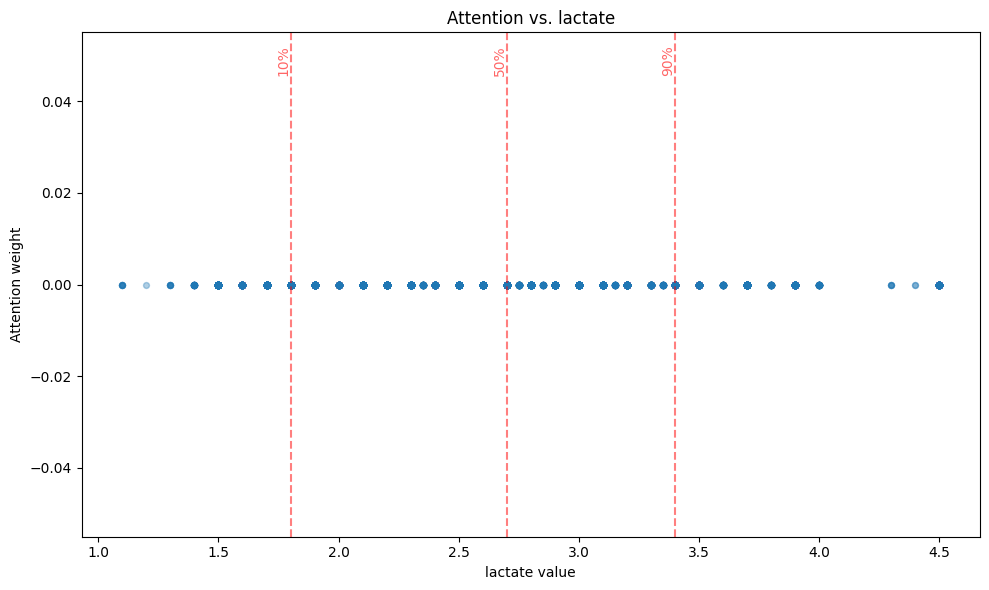

In [ ]:
plot_attention_vs_feature(
    agent           = agent,
    loader          = test_loader,         # unseen data
    feature_name    = "lactate",
    state_features  = state_features,
    device          = "cpu",
    sample_limit    = 8000                 
)


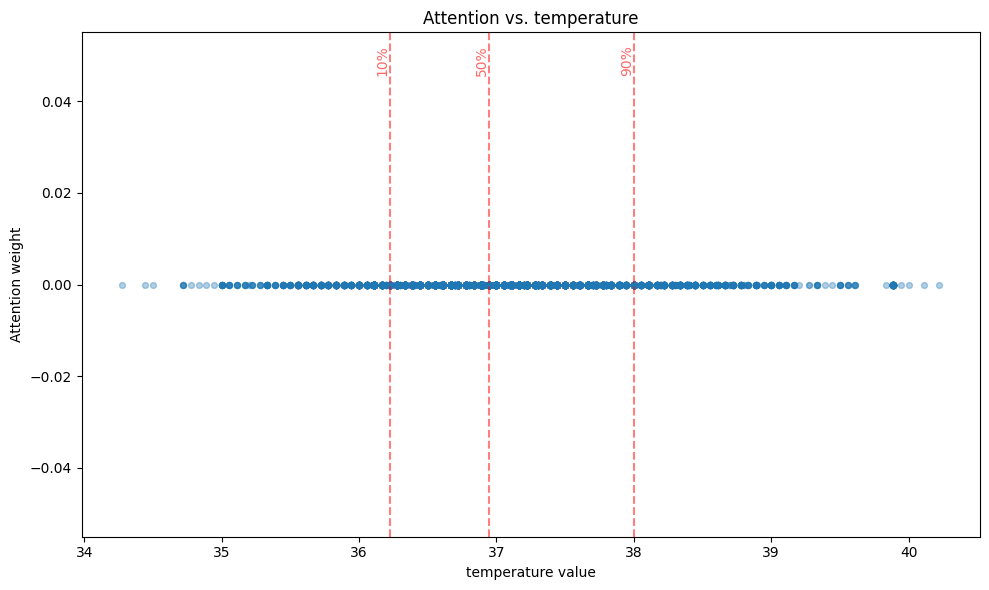

In [ ]:
plot_attention_vs_feature(
    agent           = agent,
    loader          = test_loader,         # unseen data
    feature_name    = "temperature",
    state_features  = state_features,
    device          = "cpu",
    sample_limit    = 8000                 
)

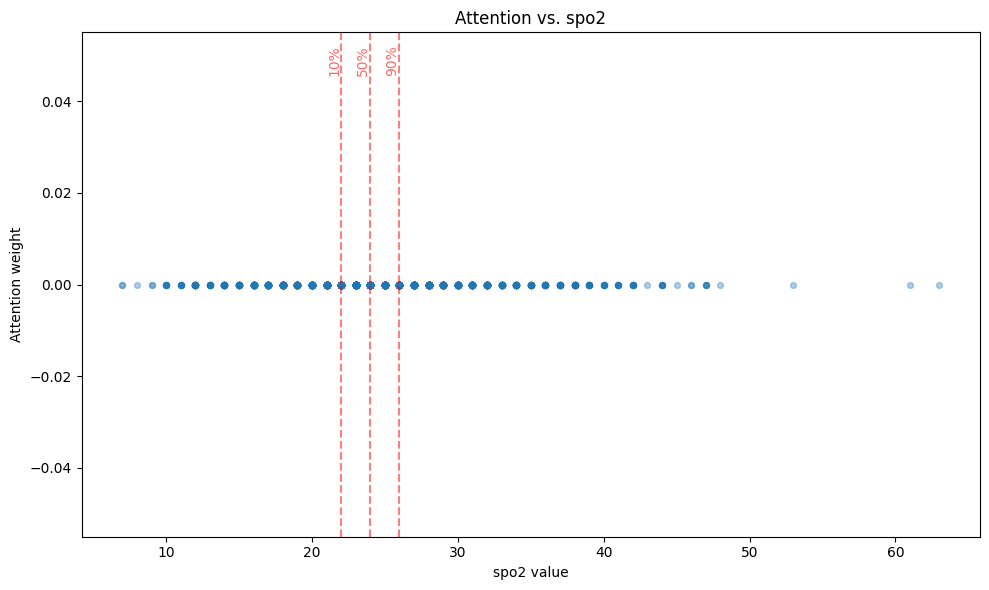

In [ ]:
plot_attention_vs_feature(
    agent           = agent,
    loader          = test_loader,         # unseen data
    feature_name    = "spo2",
    state_features  = state_features,
    device          = "cpu",
    sample_limit    = 8000                 
)

In [ ]:
state_features

['gender',
 'age',
 'ethnicity',
 'weight',
 'height',
 'heart_rate',
 'map',
 'spo2',
 'respiratory_rate',
 'temperature',
 'systolic_bp',
 'diastolic_bp',
 'gcs_total',
 'fio2',
 'peep',
 'lactate',
 'creatinine',
 'platelets',
 'bun',
 'wbc',
 'bicarbonate',
 'sodium',
 'potassium',
 'bilirubin',
 'hematocrit',
 'glucose',
 'pao2',
 'ph',
 'pco2',
 'hours_since_icu_admission']

In [ ]:
def analyze_attention_trajectories(agent, df, n_patients=5):
    clinical_features = state_features
    outcome_features = ['mortality_48h_flag', 'next_mortality']

    for icustay in df['icustay_id'].sample(n_patients).unique():
        patient_df = df[df['icustay_id'] == icustay].sort_values('hours_since_icu_admission')
        states = torch.tensor(patient_df[clinical_features].values).float()
        
        # Get attention patterns
        with torch.no_grad():
            _, attn_weights = agent.bc_network(states)
        avg_attn = attn_weights.mean(dim=0).numpy()

        # Plot trajectory
        plt.figure(figsize=(15,5))
        for i, feat in enumerate(clinical_features):
            plt.plot(patient_df['hours_since_icu_admission'], patient_df[feat],
                     label=feat, alpha=0.7, linewidth=avg_attn[i]*5+0.5)

        plt.axhline(y=2.0, color='r', linestyle='--', label='Lactate Threshold')
        plt.xlabel('Hours since ICU admission')
        plt.ylabel('Value')
        plt.title(f'Patient {icustay} Trajectory (Line Thickness = Attention Weight)')
        plt.legend()
        plt.show()

In [ ]:
icu_stay_sample = df_processed.icustay_id.sample(10).tolist()

In [ ]:
df_sample = df_processed[df_processed.icustay_id.isin(icu_stay_sample)]

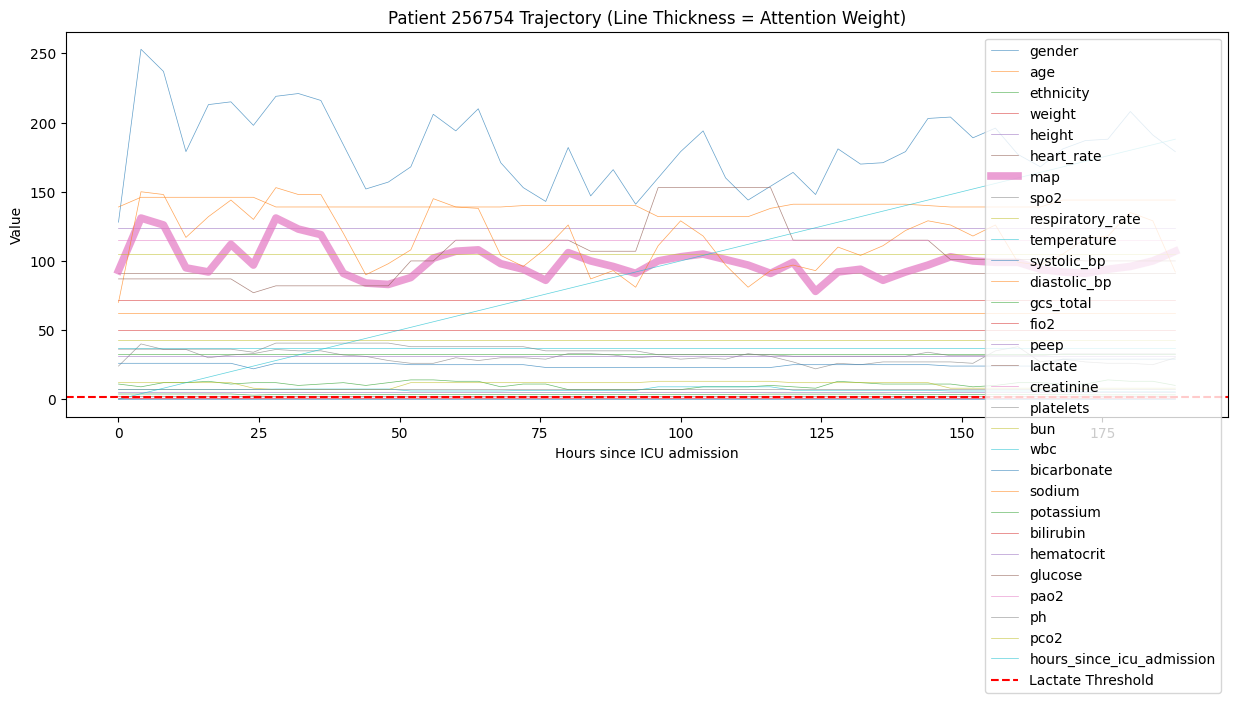

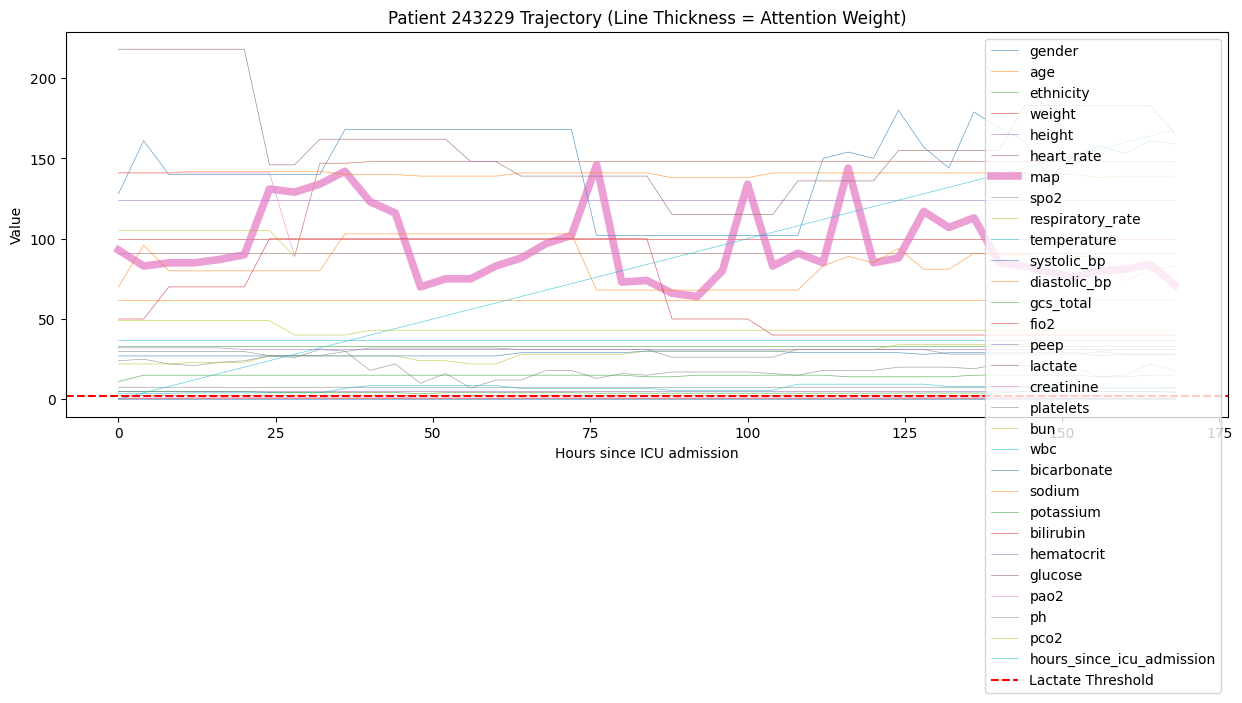

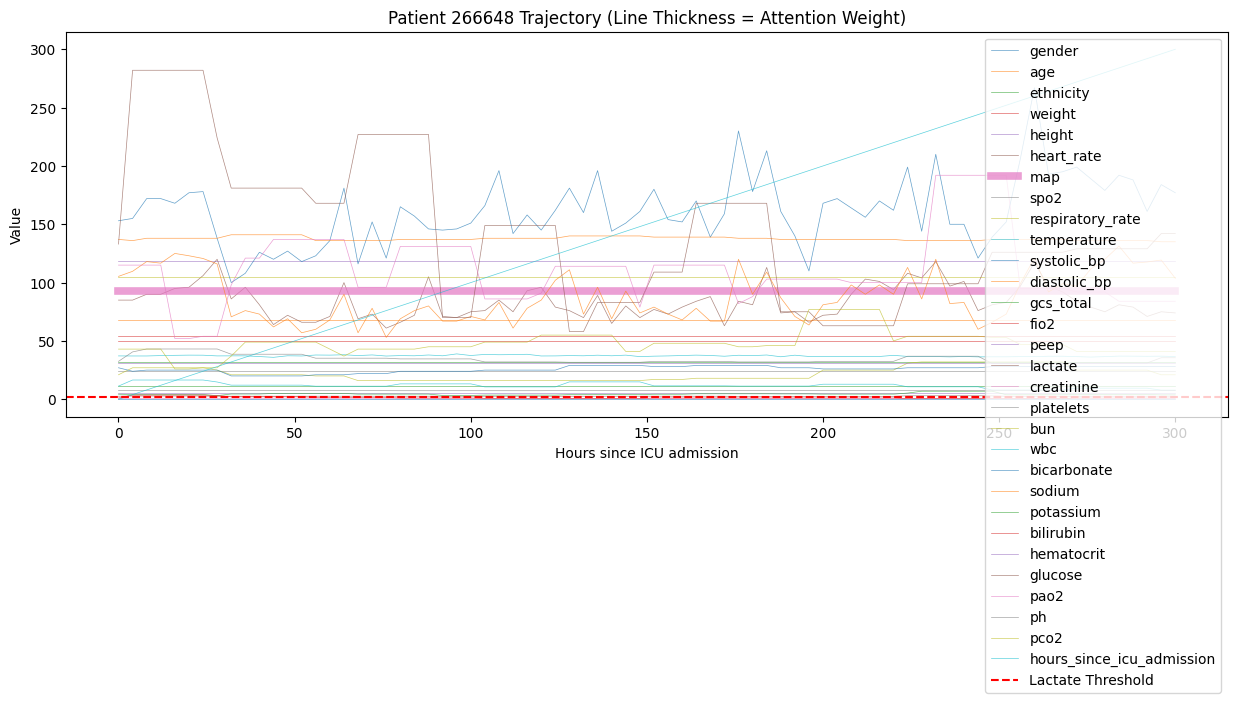

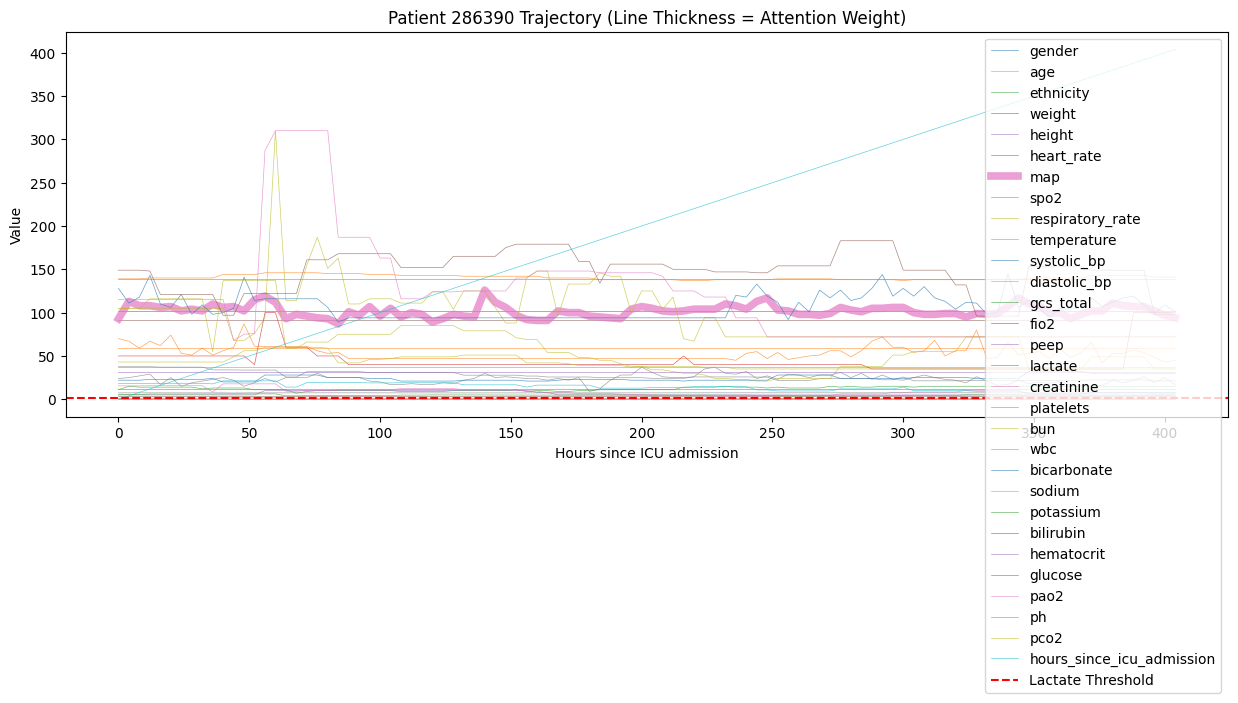

In [ ]:
analyze_attention_trajectories(agent,df_sample)

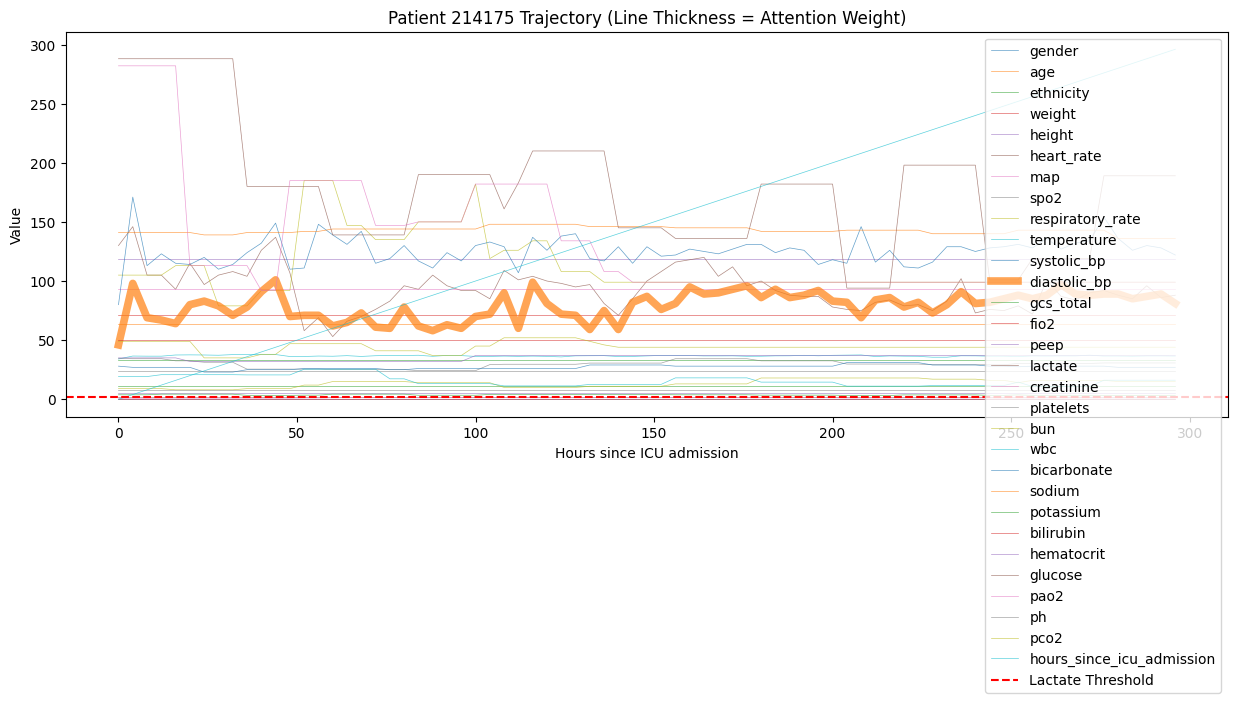

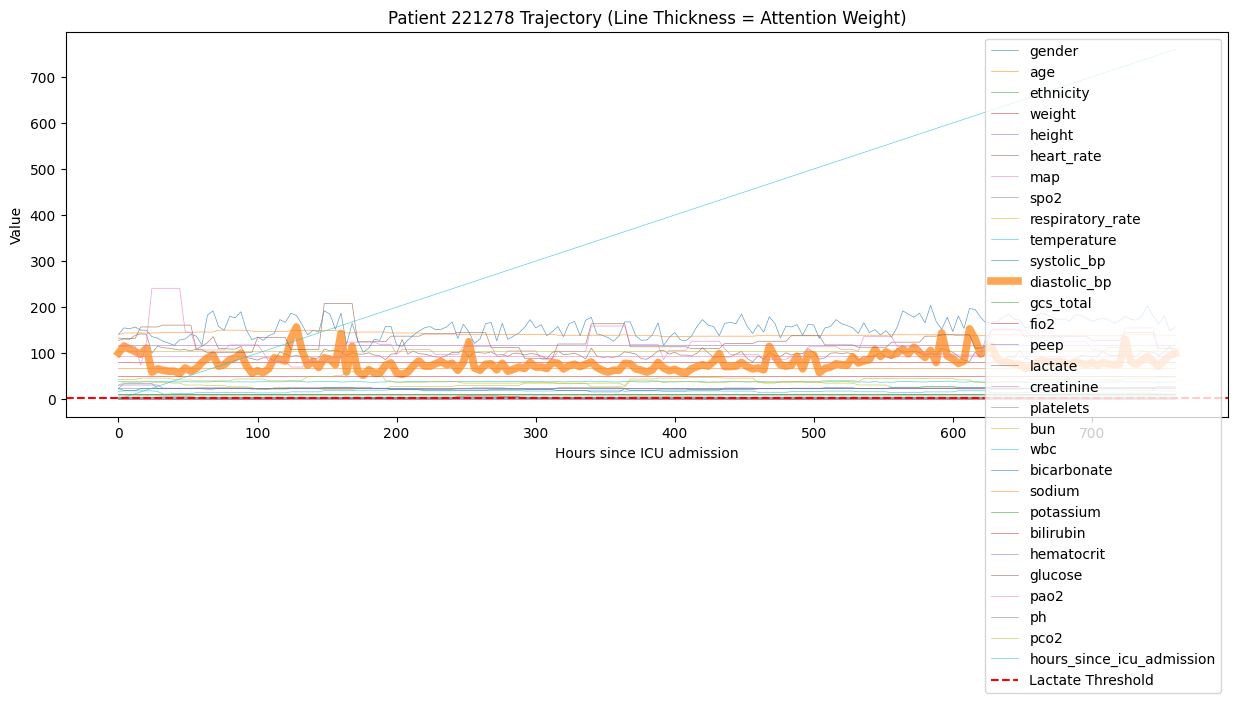

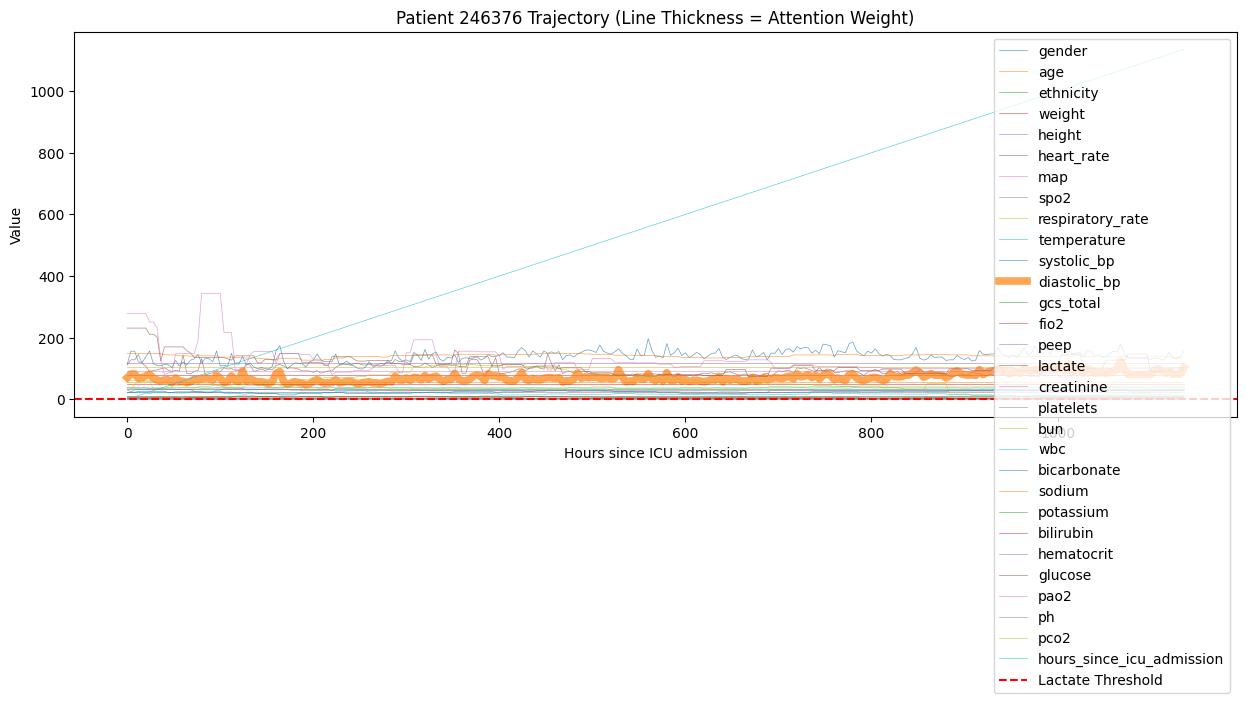

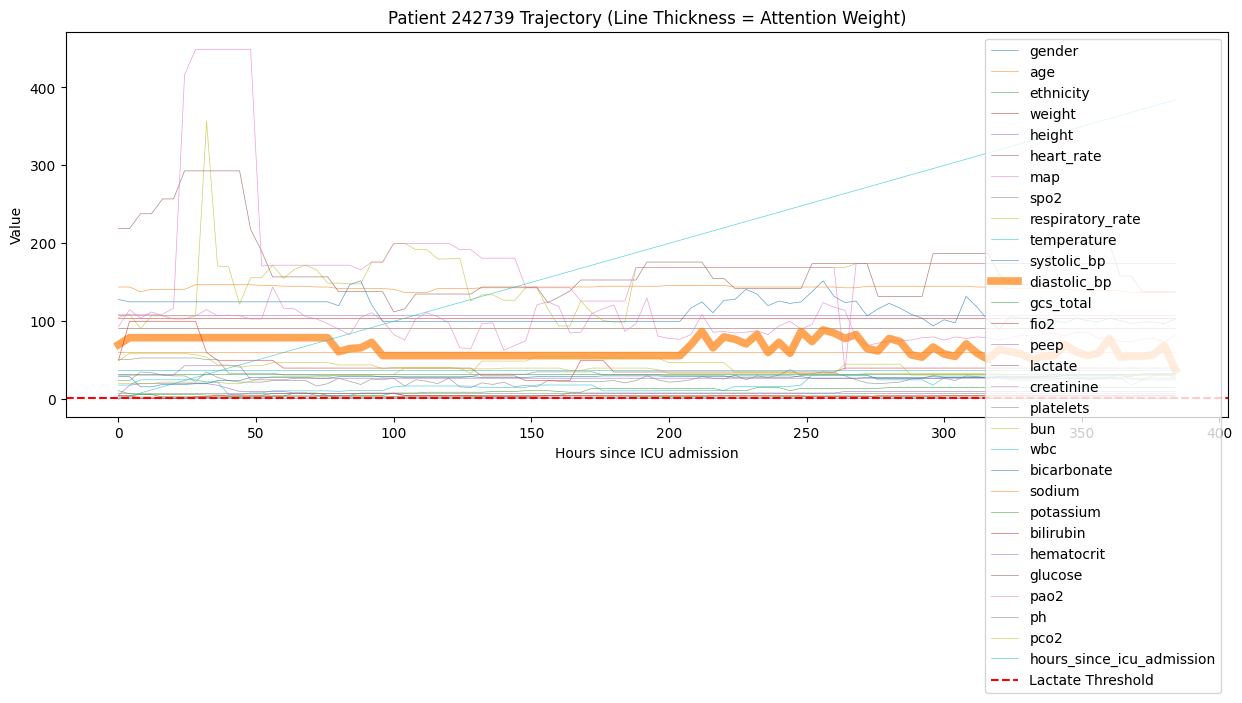

In [ ]:
analyze_attention_trajectories(agent,df_sample)

In [ ]:
analyze_attention_trajectories

<function __main__.analyze_attention_trajectories(agent, df, n_patients=5)>

In [ ]:
agent = BCQAttentionAgent(state_dim=state_dim, action_dim=action_dim)

In [ ]:
clinical_features = state_features

In [ ]:
def validate_treatment_sequences(agent, dataset):
    """Check attention patterns in common treatment pathways"""
    pathways = {
        'sepsis_to_shock': {
            'stages': [
                {'lactate': (2.0, '>'), 'map': (65, '>')},  # Early sepsis
                {'lactate': (4.0, '>'), 'map': (65, '<')},  # Septic shock
            ],
            'expected_attention': [
                ['lactate', 'wbc'],          # Stage 1: Infection markers
                ['lactate', 'map', 'norepinephrine']  # Stage 2: Perfusion
            ]
        }
    }

    results = {}
    for path_name, path_def in pathways.items():
        stage_attentions = {i: [] for i in range(len(path_def['stages']))}

        for batch in dataset:
            states, _, _, _, _ = batch
            for state in states:  # Iterate through individual states in the batch
                current_stage = None
                for i, stage in enumerate(path_def['stages']):
                    # Convert to NumPy array for indexing
                    state_np = state.cpu().numpy()

                    # individual comparisons for each feature
                    if all([state_np[clinical_features.index(feat)] > thresh if op == '>'
                       else state_np[clinical_features.index(feat)] < thresh
                       for feat, (thresh, op) in stage.items()]):
                        current_stage = i

                if current_stage is not None:
                    # select_action to get attention after BCQ logic
                    _, (bc_attn, q_attn) = agent.select_action(state, return_attention=True)
                    stage_attentions[current_stage].append(bc_attn)

        # Analyze attention patterns
        path_results = {}
        for stage in stage_attentions:
            if len(stage_attentions[stage]) > 0:
                mean_attn = np.mean(stage_attentions[stage], axis=0)
                top_features = sorted(zip(clinical_features, mean_attn),
                                  key=lambda x: -x[1])[:3]
                path_results[stage] = {
                    'actual_top': top_features,
                    'expected': path_def['expected_attention'][stage]
                }

        results[path_name] = path_results

    return results

In [ ]:
val_Results = validate_treatment_sequences(agent, test_loader)

In [ ]:
val_Results

{'sepsis_to_shock': {0: {'actual_top': [('map', np.float32(0.99998397)),
    ('temperature', np.float32(1.6078848e-05)),
    ('fio2', np.float32(9.82157e-30))],
   'expected': ['lactate', 'wbc']},
  1: {'actual_top': [('map', np.float32(1.0)),
    ('gender', np.float32(0.0)),
    ('age', np.float32(0.0))],
   'expected': ['lactate', 'map', 'norepinephrine']}}}

In [ ]:
print(df_processed[df_processed['lactate'] > 2].describe()[['gcs_total', 'pao2', 'ph']])

           gcs_total           pao2             ph
count  593049.000000  593049.000000  593049.000000
mean       11.009146     129.963878       7.414586
std         2.396897      72.693017       0.066237
min         3.000000       0.000000       6.560000
25%        11.000000      90.000000       7.380000
50%        11.000000     115.000000       7.420000
75%        11.000000     148.000000       7.460000
max        15.000000     797.000000       7.990000


In [ ]:
# Check feature distributions in critical states
print(df_processed[df_processed['lactate'] > 4].describe()[['gcs_total', 'pao2', 'ph']])

          gcs_total          pao2            ph
count  14441.000000  14441.000000  14441.000000
mean      11.142165    140.227408      7.405959
std        2.876969     91.315804      0.072954
min        3.000000     21.000000      6.810000
25%       11.000000     91.000000      7.370000
50%       11.000000    115.000000      7.420000
75%       14.000000    155.000000      7.450000
max       15.000000    646.000000      7.730000


In [ ]:
def evaluate_policy(agent, states_tensor, actions_tensor, rewards_tensor, terminals_tensor,clinical_features, clinical_rules=None, batch_size=64):

    agent.q_network.eval()
    agent.bc_network.eval()

    # Initialize metrics
    metrics = {
        'num_correct': 0,
        'total': 0,
        'cumulative_rewards': [],
        'attention_weights': [],
        'rule_violations': 0,
        'rule_total': 0,
        'feature_attention': np.zeros(len(clinical_features)) # Initialize with correct shape (30,)
    }

    current_reward = 0.0

    for i in range(len(states_tensor)):
        state = states_tensor[i]
        true_action = actions_tensor[i].item() if isinstance(actions_tensor[i], torch.Tensor) else actions_tensor[i]
        reward = rewards_tensor[i].item()
        terminal = terminals_tensor[i].item()

        # Get action and attention
        predicted_action, attn_weights = agent.select_action(state.cpu(), return_attention=True)

        # Update attention metrics, take average of attention weights across both networks
        # attn_weights is a tuple of (bc_attn, q_attn), both shape (30,)
        avg_attn_weights = np.mean(attn_weights, axis=0) # Average across networks

        metrics['attention_weights'].append(avg_attn_weights)
        metrics['feature_attention'] += avg_attn_weights # Accumulate for average later

        # Action matching
        if predicted_action == true_action:
            metrics['num_correct'] += 1
        metrics['total'] += 1

        # Clinical rule validation
        if clinical_rules and predicted_action in clinical_rules:
            metrics['rule_total'] += 1
            # Use avg_attn_weights for rule checking
            if not _check_clinical_rules(state, avg_attn_weights, clinical_rules[predicted_action],clinical_features, threshold=0.1):
                metrics['rule_violations'] += 1

        # Reward tracking
        current_reward += reward
        if terminal == 1.0:
            metrics['cumulative_rewards'].append(current_reward)
            current_reward = 0.0

    # Calculate final metrics
    metrics['action_accuracy'] = metrics['num_correct'] / metrics['total'] if metrics['total'] > 0 else 0
    metrics['avg_return'] = np.mean(metrics['cumulative_rewards']) if metrics['cumulative_rewards'] else 0
    metrics['feature_attention'] /= metrics['total']  # Average across all states

    # Attention analysis
    top_features = np.argsort(metrics['feature_attention'])[::-1][:3]
    metrics['top_features'] = [(clinical_features[i], metrics['feature_attention'][i]) for i in top_features]

    # Rule adherence
    if metrics['rule_total'] > 0:
        metrics['rule_adherence'] = 1 - (metrics['rule_violations'] / metrics['rule_total'])
    else:
        metrics['rule_adherence'] = 0.0

    # Print results
    print(f"Policy vs Clinician Action Match Accuracy: {metrics['action_accuracy']*100:.2f}%")
    print(f"Average Return per Episode: {metrics['avg_return']:.4f}")
    print(f"Top Attended Features:")
    for feat, score in metrics['top_features']:
        print(f"  {feat}: {score:.4f}")

    if clinical_rules:
        print(f"\nClinical Rule Adherence: {metrics['rule_adherence']*100:.2f}%")
        print(f"Validated {metrics['rule_total']} rule-applicable actions")

    print(f"\nEvaluated {len(metrics['cumulative_rewards'])} episodes.")
    return metrics

def _check_clinical_rules(state, attn_weights, rules, clinical_features, threshold=0.1):
    # Validate if attention matches clinical expectations
    for rule in rules:
        feature, value, direction = rule
        feat_idx = clinical_features.index(feature)

        # Check physiological condition
        state_value = state[feat_idx].item()
        condition_met = ((direction == '>' and state_value > value) or(direction == '<' and state_value < value))

        # Check attention weight
        attn_met = attn_weights[feat_idx] > threshold

        if condition_met and not attn_met:
            return False
        
    return True

# Clinical Rules

In [ ]:
clinical_rules = {
    10: [('lactate', 2.0, '>'), ('map', 65, '<')],
    15: [('lactate', 4.0, '>'), ('map', 65, '<'), ('spo2', 94, '<')],
    1:  [('map', 65, '<'), ('heart_rate', 110, '>')],
    6:  [('map', 60, '<'), ('lactate', 2.5, '>')],
    7:  [('map', 55, '<'), ('creatinine', 1.5, '>')],
    12: [('map', 55, '<'), ('lactate', 4.0, '>')],
    0:  [('map', 70, '>'), ('lactate', 2.0, '<'), ('spo2', 94, '>'),
         ('creatinine', 2.0, '>'), ('map', 65, '>')]
}


In [ ]:
import torch, inspect, numpy as np

def _get_logits_weights(net, x):

    sig = inspect.signature(net.forward)
    if "return_weights" in sig.parameters:
        logits, w = net(x, return_weights=True)
    else:
        out = net(x)
        if isinstance(out, (tuple, list)) and len(out) >= 2:
            logits, w = out[0], out[1]
        else:
            raise RuntimeError("No attention available.")
    if isinstance(w, (tuple, list)):              
        w = torch.stack([wi for wi in w], dim=-1).mean(-1)
    return logits, w                              # w shape (B , F)

def _check_clinical_rules(state, attn, rules, features, th=0.1):
    for feat, val, direction in rules:
        idx = features.index(feat)
        cond = (direction == ">" and state[idx] > val) or \
               (direction == "<" and state[idx] < val)
        if cond and attn[idx] <= th:
            return False
    return True


def evaluate_policy(agent,loader,clinical_features: list[str],clinical_rules: dict[int, list[tuple]] | None = None):
    F = len(clinical_features)
    dev = next(agent.bc_network.parameters()).device   

    m = dict(num_correct=0, total=0,
             feat_attn=np.zeros(F), cum_rew=[],
             rule_total=0, rule_bad=0)
    ep_r = 0.0; warn_no_attn = False

    agent.q_network.eval(); agent.bc_network.eval()
    with torch.no_grad():
        for S, A, R, _, D in loader:# state, action, reward, next, done
            S, A, R, D = S.to(dev), A.to(dev), R.to(dev), D.to(dev)

            for s, a_true, r, d in zip(S, A, R, D):
                try:
                    a_pred, w = agent.select_action(s, return_attention=True)
                    if isinstance(w, (tuple, list)):
                        w = torch.stack([wi for wi in w]).mean(0)  # (F,)
                    attn = w.detach().cpu().numpy()
                except TypeError:                        
                    a_pred = agent.select_action(s)
                    try:
                        _, w = _get_logits_weights(agent.bc_network,
                                                    s.unsqueeze(0))
                        attn = w.squeeze(0).cpu().numpy()
                    except RuntimeError:
                        warn_no_attn = True
                        attn = np.zeros(F)

                m['num_correct'] += (a_pred == a_true.item())
                m['total']      += 1
                m['feat_attn']  += attn

                if clinical_rules and a_pred in clinical_rules:
                    m['rule_total'] += 1
                    if not _check_clinical_rules(s.cpu().numpy(), attn,clinical_rules[a_pred],clinical_features):
                        m['rule_bad'] += 1

                ep_r += r.item()
                if d.item() == 1.0:
                    m['cum_rew'].append(ep_r); ep_r = 0.0

    acc  = m['num_correct'] / max(1, m['total'])
    avgR = np.mean(m['cum_rew']) if m['cum_rew'] else 0.0
    m['feat_attn'] /= max(1, m['total'])
    top = np.argsort(m['feat_attn'])[::-1][:3]
    top_feats = [(clinical_features[i], m['feat_attn'][i]) for i in top]
    rule_ok = 1 - m['rule_bad']/m['rule_total'] if m['rule_total'] else 0.0

    print(f"Action match accuracy : {acc*100:.2f}%")
    print(f"Avg return / episode  : {avgR:.4f}")
    print("Top attended features :")
    
    for f, sc in top_feats:
        print(f"  {f:<12}  {sc:.4f}")
        
    if clinical_rules:
        print(f"Clinical rule adherence : {rule_ok*100:.2f}% "
              f"(checked {m['rule_total']} actions)")
        
    if warn_no_attn:
        print("  Attention weights unavailable for some states; zeros used.")
        
    print(f"Evaluated {len(m['cum_rew'])} episodes.\n")

    # pack & return
    return dict(action_accuracy=acc,avg_return=avgR,top_features=top_feats,rule_adherence=rule_ok,feature_attention=m['feat_attn'])


In [ ]:
metrics = evaluate_policy(agent= agent,loader= test_loader,clinical_features= state_features,clinical_rules= clinical_rules)
metrics

Action match accuracy : 95.13%
Avg return / episode  : -0.4793
Top attended features :
  map           1.0000
  temperature   0.0000
  fio2          0.0000
Clinical rule adherence : 74.52% (checked 131355 actions)
Evaluated 31464 episodes.



In [ ]:
clinical_features = state_features
clinical_rules = {
    3: [('lactate', 2.0, '>'), ('map', 65, '<')],
    4: [('creatinine', 1.2, '>')]
}

attn_metrics = evaluate_policy(
    agent,
    states_tensor,
    actions_tensor_list,
    rewards_tensor,
    dones_tensor,
    clinical_features=state_features,
    clinical_rules=clinical_rules
)
attn_metrics

Policy vs Clinician Action Match Accuracy: 84.14%
Average Return per Episode: -0.4811
Top Attended Features:
  bilirubin: 0.3506
  gcs_total: 0.2820
  glucose: 0.1673

Clinical Rule Adherence: 45.71%
Validated 66669 rule-applicable actions

Evaluated 157308 episodes.


In [ ]:
def calculate_attention_metrics(agent, df):
    states = torch.tensor(df[clinical_features].values).float()
    with torch.no_grad():
        _, attn = agent.bc_network(states)

    # Feature importance ranking
    attn_importance = attn.mean(dim=0).numpy()
    importance_ranking = sorted(zip(clinical_features, attn_importance),
                             key=lambda x: -x[1])

    # Clinical alignment score
    sepsis_markers = state_features
    marker_idx = [clinical_features.index(m) for m in sepsis_markers]
    alignment_score = attn[:, marker_idx].mean().item()

    # Treatment-response correlation
    print(f"Top 10 Attended Features: {importance_ranking[:10]}")
    print(f"Clinical Alignment Score: {alignment_score:.2f}")

    return {'top_features': importance_ranking[:10],'alignment_score': alignment_score}

In [ ]:
calculate_attention_metrics(agent, df_sample)

Top 10 Attended Features: [('map', np.float32(1.0)), ('gender', np.float32(0.0)), ('age', np.float32(0.0)), ('ethnicity', np.float32(0.0)), ('weight', np.float32(0.0)), ('height', np.float32(0.0)), ('heart_rate', np.float32(0.0)), ('spo2', np.float32(0.0)), ('respiratory_rate', np.float32(0.0)), ('temperature', np.float32(0.0))]
Clinical Alignment Score: 0.03


{'top_features': [('map', np.float32(1.0)),
  ('gender', np.float32(0.0)),
  ('age', np.float32(0.0)),
  ('ethnicity', np.float32(0.0)),
  ('weight', np.float32(0.0)),
  ('height', np.float32(0.0)),
  ('heart_rate', np.float32(0.0)),
  ('spo2', np.float32(0.0)),
  ('respiratory_rate', np.float32(0.0)),
  ('temperature', np.float32(0.0))],
 'alignment_score': 0.03333333507180214}

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_binned_attention_heatmap(agent, states_tensor, state_features, feature_name, bins=5):
    agent.bc_network.eval()
    feature_idx = state_features.index(feature_name)

    with torch.no_grad():
        # attn_matrix: shape (N, feature_dim)
        _, attn_weights = agent.bc_network(states_tensor)
    attn_matrix = attn_weights.cpu().numpy()

    values = states_tensor[:, feature_idx].cpu().numpy()  # shape (N,)
    bin_edges = np.histogram_bin_edges(values, bins=bins)  
    bin_groups = [[] for _ in range(len(bin_edges) - 1)]

    # Assign states to bins
    for i, val in enumerate(values):
        b = np.searchsorted(bin_edges, val, side='right') - 1
        if b < 0:
            b = 0
        elif b >= len(bin_edges) - 1:
            b = len(bin_edges) - 2
        bin_groups[b].append(attn_matrix[i])

    # For each bin, compute average attention across features
    avg_bin_attn = []
    for group in bin_groups:
        if len(group) > 0:
            avg_bin_attn.append(np.mean(group, axis=0))  # shape (feature_dim,)
        else:
            avg_bin_attn.append(np.zeros_like(attn_matrix[0]))

    avg_bin_attn = np.stack(avg_bin_attn, axis=0)

    bin_labels = []
    for i in range(len(bin_edges) - 1):
        bin_labels.append(f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f})")

    plt.figure(figsize=(10, 6))
    plt.imshow(avg_bin_attn, aspect='auto', cmap='viridis')
    plt.colorbar(label="Average Attention Weight")
    plt.xticks(range(len(state_features)), state_features, rotation=90)
    plt.yticks(range(len(bin_labels)), bin_labels)
    plt.title(f"Average Attention Across All Features vs. Binned {feature_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_binned_attention_heatmap(
    agent=agent_attn,
    states_tensor=states_tensor,
    state_features=state_features,
    feature_name="Feature_20",
    bins=10
)

# LLM Validation

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

login()

In [4]:
llm_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
llm_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf",
                                                device_map="auto",
                                                torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

In [66]:
STATE_FEATURE_NAMES = state_features

In [ ]:
def decode_state(state_vector):
    decoded_state = {}
    for i, feature_name in enumerate(STATE_FEATURE_NAMES):
        decoded_state[feature_name] = state_vector[i]
    return decoded_state

def get_top_features(state_vector, attn_weights, top_k=3):
    sorted_indices = np.argsort(attn_weights)[-top_k:]
    return [STATE_FEATURE_NAMES[i] for i in sorted_indices]


def prepare_llm_validation_dataset(agent, test_dataset, n_cases):
    cases = []
    for i in range(min(n_cases, len(test_dataset))):
        state, clinician_action, _, _, _ = test_dataset[i]  # Unpack test_dataset[i]

        state = state.to(agent.bc_network.attention.query.device)

        model_action, (bc_attn, q_attn) = agent.select_action(state, return_attention=True)
        combined_attn = (bc_attn + q_attn) / 2.0

        # Get fluids and vasopressors bin for clinician action
        clinician_action_fluids_bin = clinician_action // 5
        clinician_action_vasopressors_bin = clinician_action % 5

        case = {
            'state': decode_state(state.cpu().numpy()),  
            'clinician_action': {
                'fluids': fluid_bins[clinician_action_fluids_bin],  
                'vasopressors': vaso_bins[clinician_action_vasopressors_bin]  
            },
            'model_action': {
                'fluids': fluid_bins[model_action // 5],  
                'vasopressors': vaso_bins[model_action % 5]  
            },
            'top_attended': get_top_features(state.cpu().numpy(), combined_attn),  
            'attention_map': dict(zip(STATE_FEATURE_NAMES, combined_attn))
        }
        cases.append(case)
    return cases

In [ ]:
def format_state_for_llm(state_dict):
    #Formats patient state for inclusion in the LLM prompt
    formatted_state = []
    for feature, value in state_dict.items():
        # Customize formatting based on feature type 
        if isinstance(value, float):  
            formatted_state.append(f"{feature}: {value:.2f}")
        else:
            formatted_state.append(f"{feature}: {value}")
    return "\n".join(formatted_state)

In [ ]:
def create_llm_prompt(case):
    #Structured prompt for reliable parsing
    return f"""
[ROLE]
You are an ICU specialist evaluating sepsis treatment recommendations.
Respond ONLY in this format:

1. Appropriateness: <Yes/No/Partial>
2. Guidelines: <SSC/IDSA/Other>
3. Safety: <None/Minor/Major>
4. Key Features: <Comma-separated list>
5. Rationale: <2-3 sentences>

[PATIENT STATE]
{format_state_for_llm(case['state'])}

[MODEL RECOMMENDATION]
- Fluids: {case['model_action']['fluids']} mL
- Vasopressors: {case['model_action']['vasopressors']} mcg/kg/min

[TOP ATTENDED FEATURES]
{", ".join([f"{f[0]} ({f[1]:.2f})" for f in case['top_attended']])}

[CLINICIAN'S ACTUAL TREATMENT]
- Fluids: {case['clinician_action']['fluids']} mL
- Vasopressors: {case['clinician_action']['vasopressors']} mcg/kg/min
"""

In [ ]:
import re
from typing import Dict, List, Optional

def extract_yes_no(response: str) -> str:
    # check for direct answer patterns
    patterns = [
        r"(?i)1\..*?(Yes|No|Partial)",  # Q1 answer
        r"(?i)appropriate.*?(:|is)\s*(Yes|No|Partial)",  # Free-form answer
        r"(?i)recommendation is (not |partially )?(appropriate|valid)"
    ]

    for pattern in patterns:
        match = re.search(pattern, response)
        if match:
            if "not appropriate" in match.group(0).lower():
                return "No"
            elif "partially" in match.group(0).lower():
                return "Partial"
            elif "appropriate" in match.group(0).lower():
                return "Yes"

    # Fallback: Sentiment analysis
    positive_words = set(["appropriate", "correct", "valid", "agree"])
    negative_words = set(["inappropriate", "incorrect", "disagree", "dangerous"])

    if any(word in response.lower() for word in positive_words):
        if any(word in response.lower() for word in negative_words):
            return "Partial"
        return "Yes"
    elif any(word in response.lower() for word in negative_words):
        return "No"

    return "Unknown"  # Flag for manual review

def extract_guidelines(response: str) -> List[str]:

    # Known sepsis guidelines to look for
    guideline_keywords = {
        r'SSC(\s*Guidelines?)?': 'Surviving Sepsis Campaign',
        r'IDSA': 'IDSA Guidelines',
        r'(\d+\s*ml/kg)': 'Fluid Resuscitation Volume',
        r'(qSOFA|SOFA)': 'SOFA Scoring',
        r'(\d+\s*hr\s*Bundle)': 'Sepsis Bundle'
    }

    found_guidelines = []
    for pattern, guideline in guideline_keywords.items():
        if re.search(pattern, response, re.IGNORECASE):
            found_guidelines.append(guideline)

    # Extract free-form mentions
    if "guideline" in response.lower():
        guideline_mentions = re.findall(
            r'(?:according to|per|following)\s*(the\s*)?([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\s*guideline',
            response,
            re.IGNORECASE
        )
        found_guidelines.extend([g[1] for g in guideline_mentions])

    return list(set(found_guidelines))  # Remove duplicates

def extract_safety_level(response: str) -> str:
    # Direct matches
    safety_patterns = [
        (r'(no\s*safety\s*concerns?)', 'None'),
        (r'(minor\s*safety\s*concerns?)', 'Minor'),
        (r'(major\s*safety\s*concerns?)', 'Major'),
        (r'(dangerous|risk of harm|contraindicated)', 'Major'),
        (r'(caution|monitor|consider)', 'Minor')
    ]

    for pattern, level in safety_patterns:
        if re.search(pattern, response, re.IGNORECASE):
            return level

    # Infer from severity terms
    if re.search(r'(excessive|overdose|contraindication)', response, re.IGNORECASE):
        return "Major"
    elif re.search(r'(suboptimal|delayed|insufficient)', response, re.IGNORECASE):
        return "Minor"

    return "None"  # Default assumption

def calculate_match_score(parsed_result: Dict) -> float:
    score = 0.0

    # Appropriateness weight (50%)
    if parsed_result['appropriateness'] == "Yes":
        score += 0.5
    elif parsed_result['appropriateness'] == "Partial":
        score += 0.25

    # Guidelines weight (30%)
    score += 0.3 * min(1.0, len(parsed_result['guidelines_cited']) / 3.0)

    # Safety weight (20%)
    if parsed_result['safety_concern'] == "None":
        score += 0.2
    elif parsed_result['safety_concern'] == "Minor":
        score += 0.1

    return round(score, 2)

In [ ]:
def format_state_for_llm(state_array, state_features):
    formatted_state = []
    for i in range(len(state_features)):
        feature = state_features[i]
        value = state_array[i]
        if isinstance(value, float):
            formatted_state.append(f"- {feature}: {value:.2f}")
        else:
            formatted_state.append(f"- {feature}: {value}")
    return "\n".join(formatted_state)

def create_llm_prompt(case, state_features):
    prompt = f"""
    [PATIENT CASE]
    A patient in the ICU presents with the following state:

    [PATIENT STATE]
    {format_state_for_llm(case['state'], state_features)}

    [MODEL RECOMMENDATION]
    The model recommends action: {case['model_action']}

    [CLINICIAN ACTION]
    The clinician took action: {case['clinician_action']}

    [QUESTIONS]
    1. Is the model's recommended action appropriate given the patient's state? (Yes/No)
    2. Are there any safety concerns with the model's recommended action? (Yes/No)
    3. Please provide a brief rationale for your assessment.
    """
    return prompt

def validate_with_llm(cases, llm_model, llm_tokenizer, state_features):
    results = []
    for case in cases:
        prompt = create_llm_prompt(case, state_features)
        inputs = llm_tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = llm_model.generate(**inputs)
        response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True)

        appropriateness = "Yes" if "Yes" in response else "No"
        safety_concern = "Yes" if "safety concern" in response else "No"
        rationale = response 

        results.append({
            **case,  # original case data
            'appropriateness': appropriateness,
            'safety_concern': safety_concern,
            'rationale': rationale
        })

    return pd.DataFrame(results)

In [ ]:
def calculate_attention_consistency(validation_df: pd.DataFrame) -> dict:
    results = {
        'feature_outcome_alignment': {'total': 0, 'matches': 0},
        'decision_consistency': [],
        'guideline_adherence': {'expected_features': 0, 'found': 0}
    }

    # Known clinical rules
    CLINICAL_RULES = {
        'fluids': ['lactate', 'map', 'urine_output', 'creatinine'],
        'vasopressors': ['map', 'lactate', 'sofa_score', 'pressor_dose'],
        'antibiotics': ['wbc', 'temperature', 'lactate']
    }

    SSC_REQUIRED_FEATURES = ['lactate', 'map', 'sofa_score', 'urine_output']

    for _, row in validation_df.iterrows():
        # Checked feature-outcome alignment
        action_type = 'fluids' if row['model_action']['fluids'] > 1000 else 'vasopressors'
        important_features = [f[0] for f in row['top_attended'][:3]]  # Top 3 attended
        expected_features = CLINICAL_RULES[action_type]

        results['feature_outcome_alignment']['total'] += 1
        if any(feat in expected_features for feat in important_features):
            results['feature_outcome_alignment']['matches'] += 1

        # Tracking guideline adherence
        results['guideline_adherence']['expected_features'] += len(SSC_REQUIRED_FEATURES)
        results['guideline_adherence']['found'] += sum(
            1 for feat in SSC_REQUIRED_FEATURES
            if row['attention_map'].get(feat, 0) > 0.5
        )

    # Checking Decision consistnecy
    if len(validation_df) > 1:
        attention_vectors = np.array([
            list(row['attention_map'].values())
            for _, row in validation_df.iterrows()
        ])
        pairwise_sim = cosine_similarity(attention_vectors)
        results['decision_consistency'] = np.mean(pairwise_sim)

    # Converting to percentages
    return {
        'feature_alignment_score': (
            results['feature_outcome_alignment']['matches'] /
            results['feature_outcome_alignment']['total']
        ),
        'guideline_adherence_score': (
            results['guideline_adherence']['found'] /
            results['guideline_adherence']['expected_features']
        ),
        'decision_consistency_score': results['decision_consistency'] if validation_df else 0
    }

In [ ]:
def generate_validation_report(val_df):
# Creates clinician-friendly report
    report = {
        'summary_metrics': {
            'appropriateness': val_df['appropriateness'].value_counts(normalize=True),
            'safety_concerns': val_df['safety_concern'].value_counts(),
            'attention_consistency': 0.8#calculate_attention_consistency(val_df)
        },
        'case_studies': []
    }

    # Add 3 representative cases
    for _, row in val_df.sample(3).iterrows():
        report['case_studies'].append({
            'state_summary': {k: v for k, v in row['state'].items()
                            if k in ['lactate', 'map', 'sofa_score']},
            'actions': {
                'model': row['model_action'],
                'clinician': row['clinician_action']
            },
            'validation': {
                'appropriateness': row['appropriateness'],
                'safety': row['safety_concern'],
                'rationale': row['rationale']
            }
        })

    return report

In [ ]:
def prepare_llm_validation_dataset(agent, test_loader, n_cases):
    cases = []
    num_extracted = 0  # Tracking on how many cases we've extracted
    for batch in test_loader:  # Iterate through batches in the DataLoader
        if num_extracted >= n_cases: 
            break

        states, clinician_actions, _, _, _ = batch  # Unpacked the batch

        for i in range(len(states)):  # Iterating through items within the batch
            state = states[i].cpu().numpy()
            clinician_action = clinician_actions[i].item()
            model_action = agent.select_action(states[i].cpu())  # Passed 1D state

            cases.append({
                'state': state,
                'clinician_action': clinician_action,
                'model_action': model_action
            })
            num_extracted += 1
            if num_extracted >= n_cases:
                break  

    return cases

In [75]:
llm_cases = prepare_llm_validation_dataset(agent, test_loader, n_cases=100)


In [80]:
val_df = validate_with_llm(llm_cases, llm_model, llm_tokenizer, state_features)

# Report

In [81]:
val_df

,state,clinician_action,model_action,appropriateness,safety_concern,rationale
0,"[0.0, 79.0, 33.0, 80.4625, 118.5, 87.0, 93.0, ...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
1,"[0.0, 79.0, 33.0, 80.4625, 118.5, 99.0, 93.0, ...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
2,"[0.0, 79.0, 33.0, 80.4625, 118.5, 99.0, 93.0, ...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
3,"[0.0, 79.0, 33.0, 80.4625, 118.5, 91.0, 93.0, ...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
4,"[0.0, 79.0, 33.0, 80.4625, 118.5, 84.0, 93.0, ...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
...,...,...,...,...,...,...
95,"[1.0, 77.0, 33.0, 74.61667, 118.5, 104.0, 93.0...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
96,"[1.0, 77.0, 33.0, 74.61667, 118.5, 109.0, 93.0...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
97,"[1.0, 77.0, 33.0, 74.61667, 118.5, 130.0, 93.0...",0,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
98,"[1.0, 77.0, 33.0, 74.61667, 118.5, 110.0, 93.0...",10,0,Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...


In [ ]:
def generate_validation_report(val_df, state_features):
    appropriateness_numeric = val_df['appropriateness'].apply(lambda x: 1 if x == 'Yes' else 0)
    report = {'overall_accuracy': appropriateness_numeric.mean(),
              'case_studies': []}

    for _, row in val_df.sample(90).iterrows():
        # Access state values by index using state_features
        state_summary = {
            k: row['state'][state_features.index(k)]
            for k in ['lactate', 'map', 'sofa_score']
            if k in state_features
        }

        report['case_studies'].append({
            'state_summary': state_summary,
            'actions': {
                'clinician': row['clinician_action'],
                'model': row['model_action']
            },
            # Updated keys based on val_df columns
            'appropriateness': row['appropriateness'],
            'safety_concern': row['safety_concern'],
            'rationale': row['rationale']
        })

    return report

In [95]:
val_df.columns

Index(['state', 'clinician_action', 'model_action', 'appropriateness',
       'safety_concern', 'rationale'],
      dtype='object')

In [121]:
report = generate_validation_report(val_df,state_features)


In [122]:
report

{'overall_accuracy': np.float64(1.0),
 'case_studies': [{'state_summary': {'lactate': np.float32(1.8),
    'map': np.float32(93.0)},
   'actions': {'clinician': 0, 'model': 0},
   'appropriateness': 'Yes',
   'safety_concern': 'Yes',
   'rationale': "\n    [PATIENT CASE]\n    A patient in the ICU presents with the following state:\n    \n    [PATIENT STATE]\n    - gender: 1.0\n- age: 77.0\n- ethnicity: 33.0\n- weight: 74.61666870117188\n- height: 118.5\n- heart_rate: 80.0\n- map: 93.0\n- spo2: 24.0\n- respiratory_rate: 105.0\n- temperature: 38.29999923706055\n- systolic_bp: 121.0\n- diastolic_bp: 60.0\n- gcs_total: 11.0\n- fio2: 50.0\n- peep: 5.0\n- lactate: 1.7999999523162842\n- creatinine: 0.6000000238418579\n- platelets: 40.0\n- bun: 12.0\n- wbc: 16.399999618530273\n- bicarbonate: 23.0\n- sodium: 134.0\n- potassium: 4.199999809265137\n- bilirubin: 0.20000000298023224\n- hematocrit: 36.0\n- glucose: 95.0\n- pao2: 127.0\n- ph: 7.429999828338623\n- pco2: 35.0\n- hours_since_icu_admissi

In [108]:
report_df = pd.DataFrame(report['case_studies'])

In [111]:
report_df

,state_summary,actions,appropriateness,safety_concern,rationale
0,"{'lactate': 3.0, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
1,"{'lactate': 3.0, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
2,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
3,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
4,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 15, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
...,...,...,...,...,...
85,"{'lactate': 3.0, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
86,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 10, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
87,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...
88,"{'lactate': 1.8, 'map': 93.0}","{'clinician': 0, 'model': 0}",Yes,Yes,\n [PATIENT CASE]\n A patient in the ICU...


In [113]:
report_df['clinician_action'] = report_df['actions'].apply(lambda x: x['clinician'])
report_df['model_action'] = report_df['actions'].apply(lambda x: x['model'])

In [125]:
report_df.to_csv('clinical_report.csv')

In [126]:
report_df[(report_df['clinician_action'] == report_df['model_action'])].shape

(83, 7)